In [516]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import cv2 as cv,cv2
from functools import reduce
import os
import math
import pprint as pp
from collections import deque

%matplotlib inline

### TODO
* hsl filtering
* lock down slope values
* dynamic ROI computation
* clustering of slope values
* histogram equisation
* better vantage point calculation
* video debugging pipeline
    * dump frames
    * look at all trasnformations side by side
* detecting curved lines.
    


In [448]:
# global - state information about the last painted line.
lastIteration = None

Type <class 'numpy.ndarray'>
Shape (540, 960, 3)


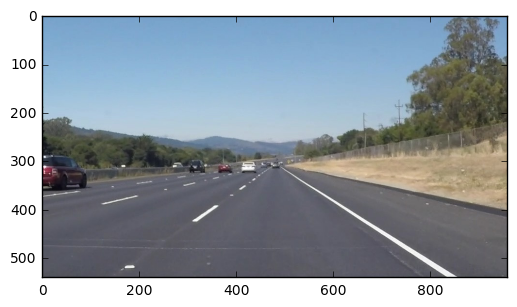

In [449]:
image = img.imread("./test_images/solidWhiteRight.jpg")
plt.imshow(image)
print("Type", type(image))
print("Shape", image.shape)

In [544]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image;

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    w = image.shape[1];
    h = image.shape[0];
    left_lines = [];
    left_lines_x = []
    left_lines_y = []
    
    right_lines = [];
    right_lines_x = []
    right_lines_y = []
    global lastIteration;
    
    if lines is None:
        print("No Lines from previous stage", lines);
        return;
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1);
            intercept = (y2 - (slope * x2));
            if abs(slope) >= .4 and abs(slope) <= .8: # need a better way filter outlier lines.
                if slope < 0:
                    left_lines_x.extend((x1,x2));
                    left_lines_y.extend((y1,y2));

                else:
                    right_lines_x.extend((x1,x2));
                    right_lines_y.extend((y1,y2));
      
    if len(left_lines_x) == 0:
        print("No Left lines detected");
        return img;
    
    if len(left_lines_y) == 0:
        print("No right lines detected");
        return img;
    
    left_fit = np.polyfit(left_lines_x, left_lines_y, 1);
    right_fit = np.polyfit(right_lines_x, right_lines_y, 1);
    
    right_slope = right_fit[0];
    right_intercept = right_fit[1];
    
    left_slope = left_fit[0];
    left_intercept = left_fit[1];

    y_top_left  = min(left_lines_y);
    y_top_right = min(right_lines_y);

    y_bottom_left = y_bottom_right = img.shape[1];
    
    # match the height of both the lines projections.
    # if unmatched the length of lines will not be same.
    # min - longer lines with a little bit of error on the curves.
    # max - shorter lines.
    y_top_left = y_top_right = min(y_top_left,y_top_right);
    
    cum_sum = currentStepData = [y_bottom_left,y_top_left,y_top_right,y_bottom_right,
                      left_slope,left_intercept,right_slope,right_intercept];

    # hold the last 10 frames data.
    if lastIteration is None:
        lastIteration = deque(maxlen=15);
 
    if lastIteration is not None:
        for item in lastIteration:
            cum_sum = np.array(cum_sum) + np.array(item);
        
    # mean
    avg = np.array(cum_sum) / (len(lastIteration) + 1);

    
    # push it into the queue
    lastIteration.append(currentStepData);
        
    # update current iteration with avg values
    y_bottom_left = avg[0];
    y_top_left = avg[1];
    y_top_right = avg[2];
    y_bottom_right = avg[3];
    left_slope = avg[4];
    left_intercept = avg[5];
    right_slope = avg[6];
    right_intercept = avg[7];
    
    # y = mx + c;
    x_bottom_left = (y_bottom_left - left_intercept) / left_slope;
    x_top_left = (y_top_left - left_intercept) / left_slope;
    
    x_bottom_right = (y_bottom_right - right_intercept) / right_slope;
    x_top_right = (y_top_right - right_intercept) / right_slope;
    
    font = cv2.FONT_HERSHEY_SIMPLEX;

    cv2.putText(img,'left slope  ' + str(left_slope) ,(10,50), font, 1, (200,255,155), 2, cv2.LINE_AA);
    cv2.putText(img,'right slope ' + str(right_slope) ,(10,100), font, 1, (200,255,155), 2, cv2.LINE_AA);

#   paint all hough lines
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness);
    
    cv2.line(img, (int(x_bottom_left), int(y_bottom_left)), (int(x_top_left),int(y_top_left)), [255,0,0], 10);
    cv2.line(img, (int(x_bottom_right), int(y_bottom_right)), (int(x_top_right),int(y_top_right)), [255,0,0], 10);

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def apply_hsv_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # opencv hsv hue range is (0-179)  
    
    lower_white = np.array([0, 0, 220])
    upper_white = np.array([179, 255, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    lower_yellow = np.array([20, 80, 200])
    upper_yellow = np.array([130, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    mask =  mask_white | mask_yellow
    return cv2.bitwise_and(image,image,mask=mask);
     


In [531]:
# testing hsl filtering
# image = img.imread("./test_images/solidWhiteCurve.jpg")
# plt.imshow(grayscale(apply_hsv_mask(image)),cmap="gray")
# apply_white_yellow_hsv_mask(image).shape
# tuple(map(tuple, np.array([[(0,h), (w*.53,h*.55), (w*.53,h*.55), (w,h)]],dtype=np.int32)[0]))[3]
# np.array([[(0,h), (w*.53,h*.55), (w*.53,h*.55), (w,h)]],dtype=np.int32)[0][1]

from collections import deque
q = deque(maxlen=3)
q.append(1)
q.append(2)
q.append(3)
q.append(4)


a = np.array([1,2,3,4])
a[0]


1

In [482]:
# bounds starting form bottom left
def getBounds(img):
    h = img.shape[0];
    w = img.shape[1];
    return np.array([[(w*.05,h), (w*.40,h*.64), (w*.60,h*.64), (w*.95,h)]],dtype=np.int32);

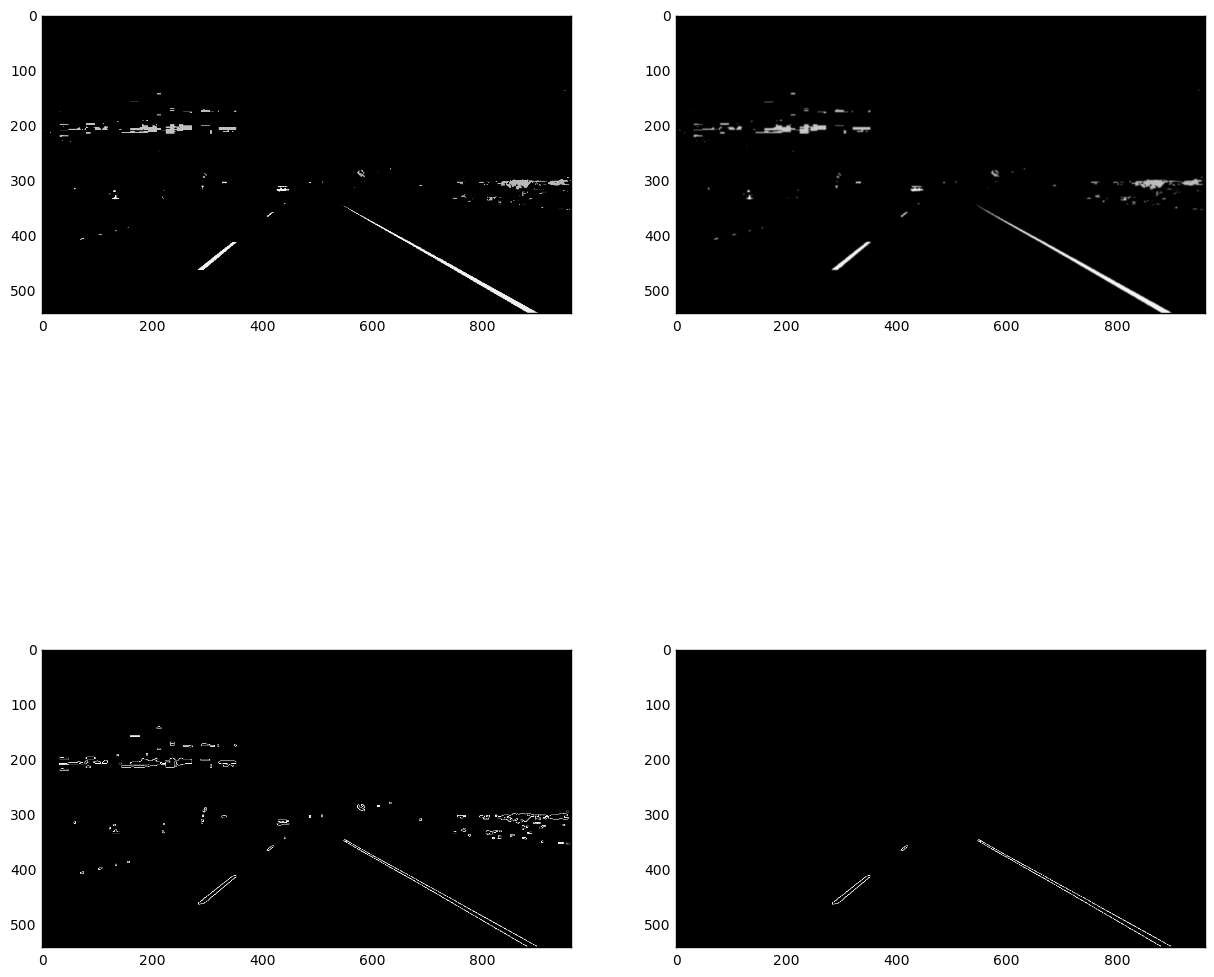

In [483]:
#  testing pipeline.
fig = plt.figure()
fig.set_size_inches(15,15)
fig_1 = fig.add_subplot(2, 2, 1)

gray_image = (grayscale(apply_hsv_mask(image)));
fig_1.imshow(gray_image,cmap="gray")
gauss_blur_img = gaussian_blur(gray_image,5)
fig_blur = fig.add_subplot(2, 2, 2)
fig_blur.imshow(gauss_blur_img,cmap="gray")

low_threshold = 0;
high_threshold = 200;
canny_image = canny(gauss_blur_img,low_threshold, high_threshold)
fig_2 = fig.add_subplot(2,2,3);
fig_2.imshow(canny_image,cmap="gray")
h = image.shape[0];
w = image.shape[1];

masked_img = region_of_interest(canny_image,getBounds(image))
bounds_fig = fig.add_subplot(2,2,4);
bounds_fig.imshow(masked_img,cmap="gray")

plt.show()

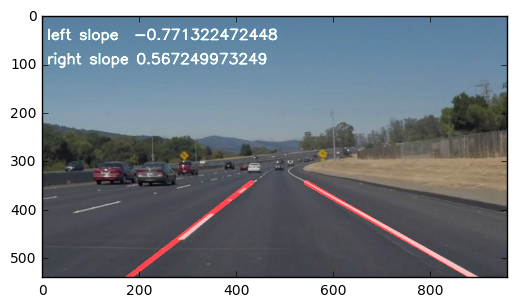

In [547]:
# testing pipeline
lastIteration = None
one_degree = np.pi / 180;
rho = 1;
theta = one_degree;
threshold = 10; # minimum number of votes
min_line_len = 10;
max_line_gap = 15;

img_with_lines = hough_lines(masked_img,rho,theta,threshold,min_line_len,max_line_gap);
plt.imshow(img_with_lines)

img_v1 = weighted_img(img_with_lines,image)
plt.imshow(img_v1)


In [548]:
# production pipeline 
def detectLanes(src_image):
    gray_image = grayscale(apply_hsv_mask(src_image));
    gauss_blur_img = gaussian_blur(gray_image,11);

    low_threshold = 100;
    high_threshold = 220;
    canny_image = canny(gauss_blur_img,low_threshold, high_threshold);
    # bounds starting form bottom left
    masked_img = region_of_interest(canny_image,getBounds(src_image));

    one_degree = np.pi / 180;
    rho = 2;
    theta = one_degree * 2;
    threshold = 22; # minimum number of votes
    min_line_len = 9;
    max_line_gap = 30;

    img_with_lines = hough_lines(masked_img,rho,theta,threshold,min_line_len,max_line_gap);
    return weighted_img(img_with_lines,src_image);

Processed  ./test_images/solidWhiteCurve.jpg
Processed  ./test_images/solidWhiteRight.jpg
Processed  ./test_images/solidYellowCurve.jpg
Processed  ./test_images/solidYellowCurve2.jpg
Processed  ./test_images/solidYellowLeft.jpg
Processed  ./test_images/whiteCarLaneSwitch.jpg


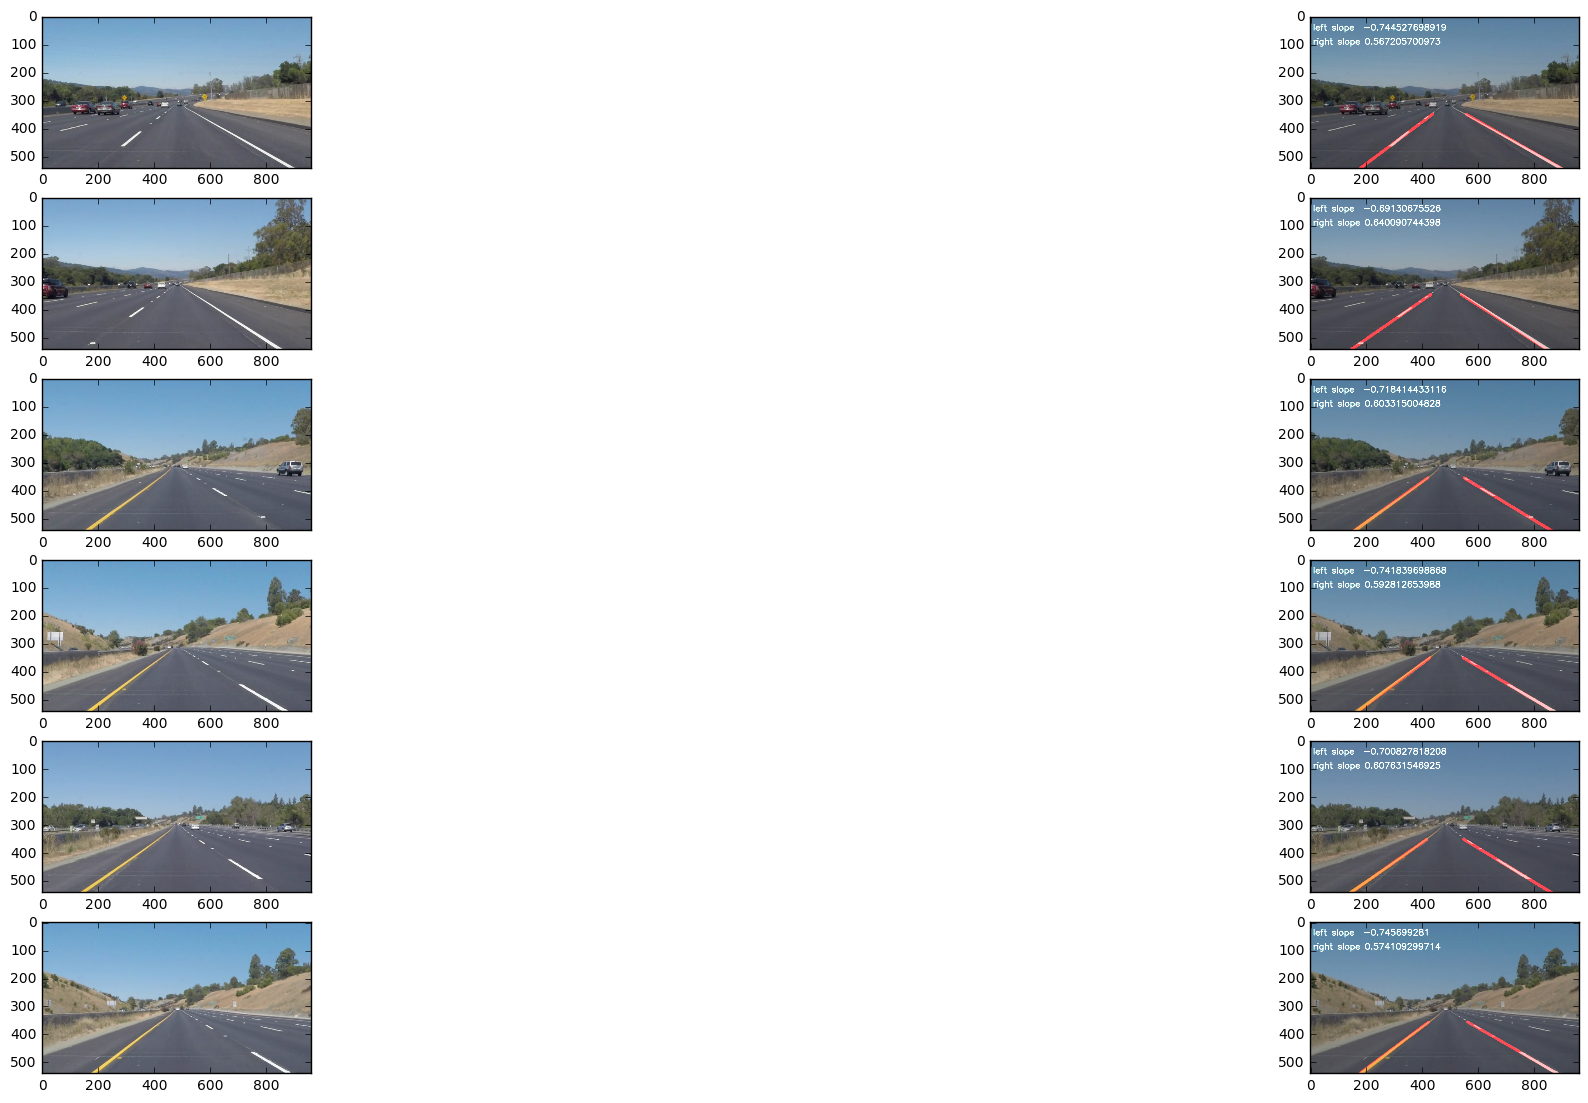

In [549]:
test_dir = "./test_images/"
no_of_img = len(os.listdir(test_dir));
fig = plt.figure();
fig.set_size_inches(30,30);
img_no = 1;
file_prefix = "processed_";
for file in os.listdir(test_dir):
    if file.startswith(file_prefix) is False and file.endswith(".jpg"):
        lastIteration = None
        src_fig = fig.add_subplot(no_of_img, 2, img_no)
        src_fig.imshow(img.imread(test_dir+file))    
        img_no = img_no + 1    
        img_fig = fig.add_subplot(no_of_img, 2, img_no)
        processed_image = detectLanes(img.imread(test_dir+file));
        img_fig.imshow(detectLanes(img.imread(test_dir+file)),cmap="gray")
        img_no = img_no + 1
        plt.imsave(test_dir+"processed_"+file , processed_image);
        print("Processed ", test_dir+file)
plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [471]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [550]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detectLanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [551]:
lastIteration = None;
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



100%|█████████▉| 221/222 [00:04<00:00, 44.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.39 s, sys: 1.37 s, total: 6.76 s
Wall time: 5.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [552]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [553]:
lastIteration = None;
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:14<00:00, 46.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.5 s, sys: 3.95 s, total: 20.4 s
Wall time: 15.4 s


In [555]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Pipeline Discription

### The pipeline flow 
##### Raw image -> hsl mask -> grayscale -> gaussian blur -> canny edge detection -> mask by region of intrest -> hough transform -> line positioning

#### HSL making
* masking colours other white and yellow to improves detection further down the pipeline. But this is not a very robust solution as we cannot always expect the lines to white and yellow.

#### Gaussian blur
* Applying a blur helps deal with the rough edges from the HSL mask.

#### Region of interest mask.
* masking areas other than the region of interest gets rid of the edges detected in the unwanted regions. 
* But deciding on the region of interest manually does not scale well for different camera placements, change in camera angle, change of image resolution.
* The region of interest will have to be calculated algorithmically using some technique such as vantage point of the road, camera position metadata.


#### Line positioning.

 ###### Currently implemented method:
    * Lines from the hough transform are grouped by the sign of the slope into left lanes and right lanes.
    * Lines which does not fall into a given slope range are dropped.
    * calculate the best fitting line from the above step using linear regression. (numpy polyfill)
    * calculate the coordinates longest of the available lines used for regression for left and right lanes.
    * Mean of the last 15 frames line parameters is taken to reduce jitter in the video.
    * draw the final extrapolated lane with the slope/intercept form the regression.
    
###### Issues and improvements:
    * The system would be better if it detected more than two lanes.(improvement)
        - Instead of filtering lines based on the slope. the lines should be clustered to provide more than one lane.  
        - The current implementation is built on the assumption that one line has a positive slope and another with a negative slope.   
        
    * When the car is on a curve the output from hough transform detects the lines on the curve. Since we are fitting a line. The extrapolated line is not be able to follow the shape of the curve. fitting a polynomial instead of a line might retain the information about the curved segments.
    * The current test video is not in the urban environment so the signs on the tarmac are not present. But this pipeline might have a some trouble differentiating an "L or arrow" sign and the lane lines. 
        


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [556]:
lastIteration = None
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:09<00:00, 25.39it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.3 s, sys: 2.16 s, total: 12.5 s
Wall time: 10.9 s


In [557]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))